# Saving and loading

We often want to save the parameters of a trained model, so that we can use it again later without needing to re-train. 

All Feedbax components—including, automatically and for free, any that you might write—are [PyTrees](/feedbax/examples/pytrees): they are represented as tree-structured data. Equinox is able to [save](https://docs.kidger.site/equinox/examples/serialisation/) this data to a file. 

Feedbax provides some functions to make this slightly easier. However, you can also [learn](https://docs.kidger.site/equinox/api/serialisation/) to use the Equinox functions `tree_serialise_leaves` and `tree_deserialize_leaves`, if you prefer a different scheme for saving and loading.

Here's an example of how to use the functions provided by Feedbax. 

We'll start by writing a function that sets up the components we're going to want to save.

In [1]:
import jax

from feedbax.task import SimpleReaches

from feedbax.xabdeef.losses import simple_reach_loss
from feedbax.xabdeef.models import point_mass_nn


# The leading asterisk forces all the arguments to be passed as keyword arguments
def setup(*, workspace, n_steps, dt, hidden_size, key):

    task = SimpleReaches(
        loss_func=simple_reach_loss(), 
        workspace=workspace, 
        n_steps=n_steps
    )

    model = point_mass_nn(task, dt=dt, hidden_size=hidden_size, key=key)
    
    return task, model 

then use this function to get a task and model. We'll also want to save the parameters we use to set up the task and model, so let's store them together in a dictionary called `hyperparameters`.

In [2]:
hyperparameters = dict(
    workspace=((-1., -1.),  # Workspace bounds ((x_min, y_min), (x_max, y_max)
               (1., 1.)),
    n_steps=100,  # Number of time steps per trial
    dt=0.05,  # Duration of a time step
    hidden_size=50,  # Number of units in the hidden layer of the controller
)

key_init, key_train, key_eval = jax.random.split(jax.random.PRNGKey(0), 3)

task, model = setup(**hyperparameters, key=key_init)

Now train the model to perform the task. We'll just do a short run of 500 batches, since in this case we're interested in whether a model can be successfully saved and reloaded, regardless if it's fully converged on a solution.

In [3]:
import optax

from feedbax.trainer import TaskTrainer


trainer = TaskTrainer(
    optimizer=optax.adam(learning_rate=1e-2)
)

model_trained, _ = trainer(
    task=task, 
    model=model, 
    n_batches=500, 
    batch_size=250, 
    where_train=lambda model: model.step.net,
    key=key_train,
)

compile:   0%|          | 0/1 [00:00<?, ?it/s]

Training step compiled.
Validation step compiled.


train batch:   0%|          | 0/500 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 2.71e+01
	validation loss: 6.54e+00

Training iteration: 100
	training loss: 7.46e-02
	validation loss: 1.29e-02

Training iteration: 200
	training loss: 8.29e-03
	validation loss: 1.48e-03

Training iteration: 300
	training loss: 6.85e-03
	validation loss: 1.17e-03

Training iteration: 400
	training loss: 5.42e-03
	validation loss: 1.04e-03

Training iteration: 499
	training loss: 4.83e-03
	validation loss: 9.14e-04

Completed training run on a total of 125,000 trials.


Now let's save our task and trained model to a file, then immediately load it again.

In [4]:
from feedbax import save, load

save_path = "example_save.eqx"  

save(
    save_path,
    (task, model_trained),
    hyperparameters=hyperparameters, 
)

In [5]:
task_loaded, model_loaded = load(save_path, setup)

TODO: option to just load hyperparameters/return only the initialized model

How does this work, and why do we pass `setup` to `load`?

The short explanation is that the shape of the data we pass to `save`---in this case a tuple `(task, model)`---has to match the shape of the data returned by the `setup` function which we'll eventually pass to `load`. Also, we can pass hyperparameters to `save` to be used by `load` to call `setup` properly.

!!! NOTE     
    Python includes the module [`pickle`](https://docs.python.org/3/library/pickle.html), which can save and load entire Python objects without needing to specify, at the time of loading, how those objects were created---that is, it doesn't require us to hold on to a function like `setup` between save time and load time. This seems convenient, but it is not good practice in general:

    - Upon loading, Python will automatically execute code found in a pickle file, in order to reconstruct the pickled objects. This is a security issue. If someone shares a pickled model with you, they (or an interloper) could insert harmful code into the pickle file, and you may not know it's there until you run it.
    - Some of the components we use, such as `lambda` expressions, are not compatible with `pickle`.
    - You probably still have to keep track of how the objects in the pickle were created, for your research to be reproducible in detail. You could pickle `setup` as well---you could try to pickle *all* of your code, even---except you'd still run into the preceding issues. In the long run, the more explicit and organized solution is preferable, though it takes a little more work to start.
    
    See the Equinox [documentation](https://docs.kidger.site/equinox/examples/serialisation/) for a similar discussion of these limitations.

The longer explanation:

- We wrote `setup` as a reproducible way to (re)build our model and task.
- `hyperparameters` bundles together all the arguments we passed to `setup` to construct our specific model and task.
- We passed `(task, model_trained)` to `save` because this matches the return value of our setup function: `task, model = setup(...)`.
- `save`:
    1. calls `equinox.tree_serialize_leaves` to write `(task, model_trained)` to the file at `path`
    2. appends `hyperparameters` to the same file
- `load`:
    1. loads `hyperparameters` from the file
    2. generates a skeleton `(task, model)` by passing `hyperparameters` to `setup`, along with a dummy key---the key doesn't matter, since we'll soon be overwriting with the reloaded data
    3. fills the skeleton by loading the data that `save` had saved to the file, from `(task, model_trained)`. It does this using 
    4. returns `task, model`, which in this case we assign to `task_loaded, model_loaded` so we can distinguish them from the task and model
    
In summary: `load` expects that the file it loads will contain data that matches the kind of PyTree generated by `setup`. That will be true, if when we call `save`, we pass it a PyTree that matches the return value of `setup`. 

In general, `save` and `load` can be used to save the contents of *any* PyTree, so long as it's the same kind of PyTree returned by the setup function. In this case, that PyTree has a structure that looks like `(task, model)`---whose type is `tuple[AbstractTask, AbstractModel]`. But at some other moment, maybe we'll just care about storing the model, and not the task. We could easily have achieved that:

```python
def setup(*, .., key):
    model = ..
    return model

model = setup(**hyperparameters, key=key_init)
    
# Train the model 
# ...

save(
    save_path, 
    model,
    hyperparameters=hyperparameters,
)
    
model = load(save_path, setup)
```

Or, we could achieve the same thing by wrapping our existing setup function to make sure that its return value is the same kind of PyTree as what we pass to `save`.

In [9]:
save_path_model_only = "example_save_model_only.eqx"  

save(
    save_path_model_only,
    model_trained,
    hyperparameters=hyperparameters, 
)

def setup_model_only(**kwargs):
    _, model = setup(**kwargs)
    return model

model_loaded = load(
    save_path_model_only, 
    setup_model_only,
)

Finally, we can compare the trained model with itself after reloading, to show that the process of saving to a file preserves the model.

First, the original:

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

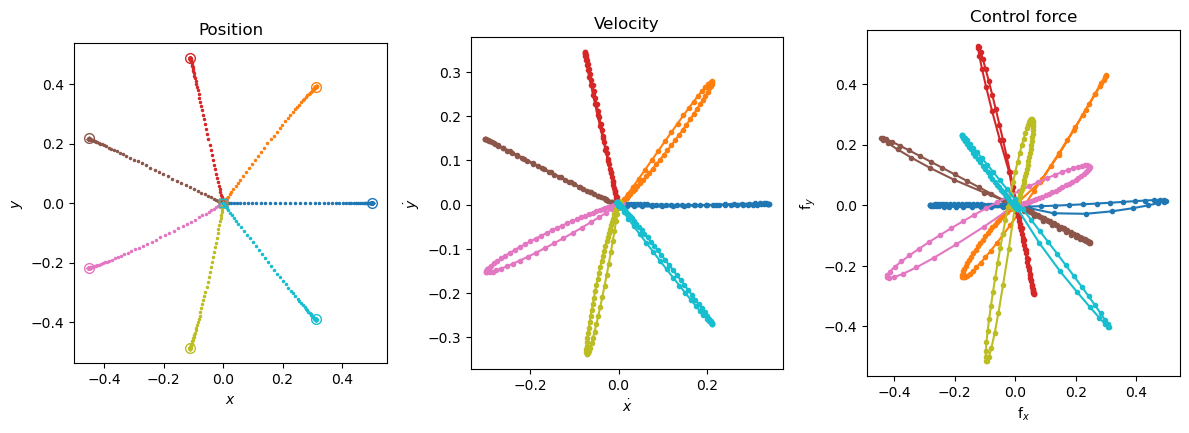

In [6]:
from feedbax.plot import plot_reach_trajectories

states = task.eval(model_trained, key=key_eval)

plot_reach_trajectories(
    states,
    trial_specs = task.validation_trials,
)

And the reloaded copy:

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

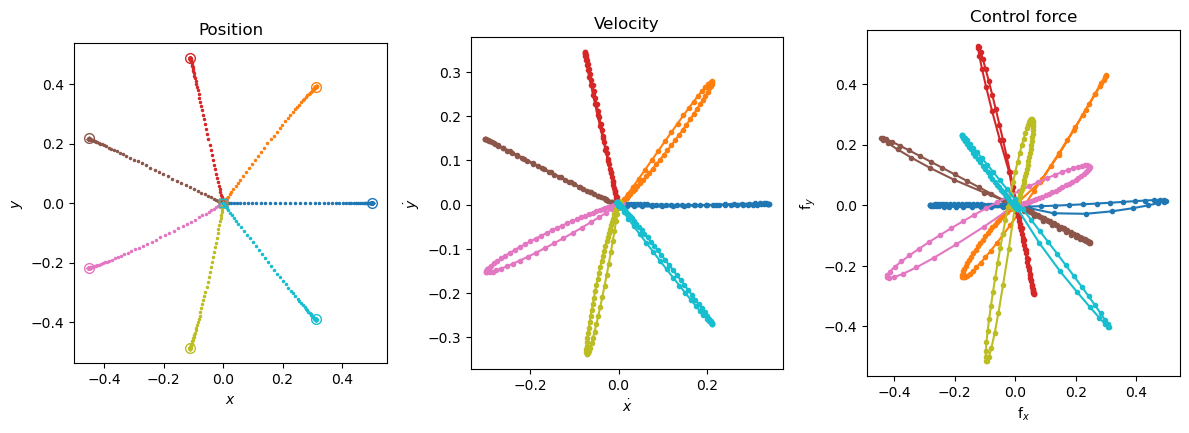

In [7]:
states = task_loaded.eval(model_loaded, key=key_eval)

plot_reach_trajectories(
    states,
    trial_specs = task.validation_trials,
)